In [40]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

In [2]:
df = pd.read_csv('data/training.csv')
df.shape

(95662, 16)

In [3]:
df.groupby('FraudResult').min()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
FraudResult,,,,,,,,,,,,,,,
0,TransactionId_1,BatchId_100,AccountId_1,SubscriptionId_10,CustomerId_1,UGX,256,ProviderId_1,ProductId_1,airtime,ChannelId_1,-1000000.0,2,2018-11-15T02:18:49Z,0
1,TransactionId_100029,BatchId_101131,AccountId_1178,SubscriptionId_1100,CustomerId_1122,UGX,256,ProviderId_1,ProductId_10,airtime,ChannelId_1,-900000.0,500,2018-11-15T08:04:51Z,0


In [4]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [6]:
df.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

## --> The following columns have just 1 distinct value and are therefore redundant:
## - CurrencyCode
## - CountryCode

## Column "Value" is redundant as the same information (more distinct) is included in column "amount" 

## Checking logical relationship between BatchId and TransactionId: 
## --> One-to-many relatinship confirmed! BatchId column is just an aggregation and therefore redundant!

In [7]:
# number of unique BatchId-values by TransactionId
b_t = df.groupby('TransactionId').BatchId.nunique()
b_t.sort_values(ascending = False)

TransactionId
TransactionId_1        1
TransactionId_57870    1
TransactionId_57885    1
TransactionId_57883    1
TransactionId_57881    1
                      ..
TransactionId_1557     1
TransactionId_15568    1
TransactionId_15567    1
TransactionId_15566    1
TransactionId_99999    1
Name: BatchId, Length: 95662, dtype: int64

## Checking logical relationship between AccountId, SubscriptionId and CustomerId: 
## --> No consistent one-to-many relatinship detected!

In [8]:
# number of unique SubscriptionId-values by AccountId
a_s = df.groupby('AccountId').SubscriptionId.nunique()
a_s.sort_values(ascending = False)

AccountId
AccountId_4841    2
AccountId_1       1
AccountId_3871    1
AccountId_3873    1
AccountId_3875    1
                 ..
AccountId_2472    1
AccountId_2473    1
AccountId_2474    1
AccountId_2476    1
AccountId_998     1
Name: SubscriptionId, Length: 3633, dtype: int64

In [9]:
# number of unique AccountId-values by SubscriptionId
s_a = df.groupby('SubscriptionId').AccountId.nunique()
s_a.sort_values(ascending = False)

SubscriptionId
SubscriptionId_4674    3
SubscriptionId_3829    2
SubscriptionId_375     2
SubscriptionId_3495    2
SubscriptionId_3489    2
                      ..
SubscriptionId_2484    1
SubscriptionId_2485    1
SubscriptionId_2487    1
SubscriptionId_2488    1
SubscriptionId_999     1
Name: AccountId, Length: 3627, dtype: int64

In [10]:
# number of unique CustomerId-values by SubscriptionId
s_c = df.groupby('SubscriptionId').CustomerId.nunique()
s_c.sort_values(ascending = False)

SubscriptionId
SubscriptionId_3829    2623
SubscriptionId_4346     182
SubscriptionId_4429      56
SubscriptionId_4836      31
SubscriptionId_3350      14
                       ... 
SubscriptionId_2485       1
SubscriptionId_2487       1
SubscriptionId_2488       1
SubscriptionId_2489       1
SubscriptionId_999        1
Name: CustomerId, Length: 3627, dtype: int64

In [11]:
# number of unique SubscriptionId-values by CustomerId
c_s = df.groupby('CustomerId').SubscriptionId.nunique()
c_s.sort_values(ascending = False)

CustomerId
CustomerId_3716    3
CustomerId_1335    3
CustomerId_4113    3
CustomerId_462     3
CustomerId_4622    3
                  ..
CustomerId_4369    1
CustomerId_4367    1
CustomerId_2141    1
CustomerId_2143    1
CustomerId_1       1
Name: SubscriptionId, Length: 3742, dtype: int64

In [12]:
# number of unique CustomerId-values by AccountId
a_c = df.groupby('AccountId').CustomerId.nunique()
a_c.sort_values(ascending = False)

AccountId
AccountId_4841    2577
AccountId_4840    1723
AccountId_10       182
AccountId_4249      56
AccountId_1074      20
                  ... 
AccountId_2474       1
AccountId_2476       1
AccountId_2477       1
AccountId_2478       1
AccountId_998        1
Name: CustomerId, Length: 3633, dtype: int64

In [13]:
# number of unique AccountId-values by CustomerId
c_a = df.groupby('CustomerId').AccountId.nunique()
c_a.sort_values(ascending = False)

CustomerId
CustomerId_606     5
CustomerId_4336    4
CustomerId_1438    4
CustomerId_3716    4
CustomerId_3391    4
                  ..
CustomerId_4683    1
CustomerId_2636    1
CustomerId_4678    1
CustomerId_4677    1
CustomerId_1       1
Name: AccountId, Length: 3742, dtype: int64

## Checking logical relationship between ProductCategory and ProductId: 
## --> One-to-many relatinship confirmed! ProductCategory column is just an aggregation and therefore redundant!

In [14]:
# list ProductId-values by ProductCategory (incl. count of Transactions)
df.groupby(['ProductCategory', 'ProductId']).count()['TransactionId']

ProductCategory     ProductId   
airtime             ProductId_1      2885
                    ProductId_10    15384
                    ProductId_16       10
                    ProductId_23        1
                    ProductId_3     24344
                    ProductId_4      2403
data_bundles        ProductId_11     1377
                    ProductId_2       236
financial_services  ProductId_14      789
                    ProductId_15    11964
                    ProductId_6     32635
                    ProductId_9        17
movies              ProductId_24      175
other               ProductId_12        2
ticket              ProductId_20      216
transport           ProductId_5        25
tv                  ProductId_19      965
                    ProductId_27       31
                    ProductId_7        86
                    ProductId_8       197
utility_bill        ProductId_13      296
                    ProductId_21     1512
                    ProductId_22      112
N

In [15]:
# number of unique ProductCategory-values by ProductId
p_pc = df.groupby('ProductId').ProductCategory.nunique()
p_pc.sort_values(ascending = False)

ProductId
ProductId_1     1
ProductId_22    1
ProductId_8     1
ProductId_7     1
ProductId_6     1
ProductId_5     1
ProductId_4     1
ProductId_3     1
ProductId_27    1
ProductId_24    1
ProductId_23    1
ProductId_21    1
ProductId_10    1
ProductId_20    1
ProductId_2     1
ProductId_19    1
ProductId_16    1
ProductId_15    1
ProductId_14    1
ProductId_13    1
ProductId_12    1
ProductId_11    1
ProductId_9     1
Name: ProductCategory, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

## --> Removing redundant columns

In [17]:
# Remove these columns:
drop_lst = ['BatchId', 'CurrencyCode', 'CountryCode', 'ProductCategory', 'Value']
# we would like to consider all variables except the ones mentioned above
remaining_features = [x for x in df.columns if x not in drop_lst]
df2 = df[remaining_features]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   AccountId             95662 non-null  object 
 2   SubscriptionId        95662 non-null  object 
 3   CustomerId            95662 non-null  object 
 4   ProviderId            95662 non-null  object 
 5   ProductId             95662 non-null  object 
 6   ChannelId             95662 non-null  object 
 7   Amount                95662 non-null  float64
 8   TransactionStartTime  95662 non-null  object 
 9   PricingStrategy       95662 non-null  int64  
 10  FraudResult           95662 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 8.0+ MB


## Feature Engineering

In [18]:
a = df['TransactionStartTime'].tolist()
b = []
for i in range (len(a)):
    b.append(a[i][-1])
set(b)

{'Z'}

In [19]:
# Datatype TransactionStartTime
df2['TransactionStartTime'] = df2['TransactionStartTime'].str.replace('T', ' ')
df2['TransactionStartTime'] = df2['TransactionStartTime'].str.replace('Z', '')
df2['TransactionStartTime'] = pd.to_datetime(df2['TransactionStartTime']) 

<ipython-input-19-d54e636aded6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TransactionStartTime'] = df2['TransactionStartTime'].str.replace('T', ' ')
<ipython-input-19-d54e636aded6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TransactionStartTime'] = df2['TransactionStartTime'].str.replace('Z', '')
<ipython-input-19-d54e636aded6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [20]:
df2.TransactionStartTime.max()

Timestamp('2019-02-13 10:01:28')

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TransactionId         95662 non-null  object        
 1   AccountId             95662 non-null  object        
 2   SubscriptionId        95662 non-null  object        
 3   CustomerId            95662 non-null  object        
 4   ProviderId            95662 non-null  object        
 5   ProductId             95662 non-null  object        
 6   ChannelId             95662 non-null  object        
 7   Amount                95662 non-null  float64       
 8   TransactionStartTime  95662 non-null  datetime64[ns]
 9   PricingStrategy       95662 non-null  int64         
 10  FraudResult           95662 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 8.0+ MB


In [22]:
# introducing columns for year, month, day, hour, minute, seconds, week and weekday
#df2['Year'] = df2['TransactionStartTime'].dt.year
#df2['Month'] = df2['TransactionStartTime'].dt.month
#df2['Day'] = df2['TransactionStartTime'].dt.day
df2['Hour'] = df2['TransactionStartTime'].dt.hour
#df2['Minute'] = df2['TransactionStartTime'].dt.minute
df2['Seconds'] = df2['TransactionStartTime'].dt.second
#df2['week'] = df2['TransactionStartTime'].dt.week
df2['Weekday'] = df2['TransactionStartTime'].dt.weekday
df2.drop('TransactionStartTime', axis = 1, inplace = True)

<ipython-input-22-426955cea94a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Hour'] = df2['TransactionStartTime'].dt.hour
<ipython-input-22-426955cea94a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Seconds'] = df2['TransactionStartTime'].dt.second
<ipython-input-22-426955cea94a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionId    95662 non-null  object 
 1   AccountId        95662 non-null  object 
 2   SubscriptionId   95662 non-null  object 
 3   CustomerId       95662 non-null  object 
 4   ProviderId       95662 non-null  object 
 5   ProductId        95662 non-null  object 
 6   ChannelId        95662 non-null  object 
 7   Amount           95662 non-null  float64
 8   PricingStrategy  95662 non-null  int64  
 9   FraudResult      95662 non-null  int64  
 10  Hour             95662 non-null  int64  
 11  Seconds          95662 non-null  int64  
 12  Weekday          95662 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 9.5+ MB


In [24]:
df_fraud=df2[df2['FraudResult'] == 1]
df_safe=df2[df2['FraudResult'] == 0]
df_fraud.sort_values('Seconds', ascending=False).head(10)

,TransactionId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,PricingStrategy,FraudResult,Hour,Seconds,Weekday
69563,TransactionId_101987,AccountId_1609,SubscriptionId_2872,CustomerId_1988,ProviderId_3,ProductId_15,ChannelId_3,100000.0,2,1,20,59,2
55822,TransactionId_56954,AccountId_4249,SubscriptionId_4429,CustomerId_7339,ProviderId_4,ProductId_3,ChannelId_2,-900000.0,4,1,15,59,3
81757,TransactionId_107592,AccountId_572,SubscriptionId_2950,CustomerId_909,ProviderId_5,ProductId_15,ChannelId_3,1000000.0,2,1,14,59,4
64357,TransactionId_85815,AccountId_953,SubscriptionId_162,CustomerId_1302,ProviderId_3,ProductId_15,ChannelId_3,2000000.0,2,1,15,59,4
82314,TransactionId_7569,AccountId_572,SubscriptionId_2950,CustomerId_909,ProviderId_5,ProductId_15,ChannelId_3,7000000.0,2,1,17,59,4
81128,TransactionId_11322,AccountId_572,SubscriptionId_2950,CustomerId_909,ProviderId_5,ProductId_15,ChannelId_3,3000000.0,2,1,12,58,4
82892,TransactionId_49929,AccountId_572,SubscriptionId_2950,CustomerId_909,ProviderId_5,ProductId_15,ChannelId_3,3000000.0,2,1,3,58,5
36101,TransactionId_60447,AccountId_1825,SubscriptionId_4080,CustomerId_2216,ProviderId_3,ProductId_15,ChannelId_3,588668.0,2,1,17,58,4
82333,TransactionId_82482,AccountId_572,SubscriptionId_2950,CustomerId_909,ProviderId_5,ProductId_15,ChannelId_3,5000000.0,2,1,17,58,4
85515,TransactionId_114761,AccountId_2656,SubscriptionId_2912,CustomerId_3075,ProviderId_5,ProductId_13,ChannelId_3,570035.0,2,1,19,58,0


In [25]:
df3=df2[['PricingStrategy', 'Amount', 'Hour', 'Seconds', 'Weekday', 'FraudResult']]

In [26]:
X_train,X_test,y_train,y_test=train_test_split(df3.drop('FraudResult',axis=1),df3['FraudResult'],test_size=0.30,random_state=101)

In [34]:
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [35]:
predictions=logmodel.predict(X_test)

In [36]:
accuracy=accuracy_score(y_test,predictions)
accuracy*100

99.84668455346876

In [42]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

y_train_predicted = cross_val_predict(logmodel, X_train, y_train, cv=5)

actual =    y_train 
predicted = y_train_predicted

results = confusion_matrix(actual, predicted)

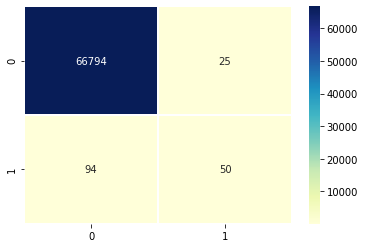

In [43]:
cm = confusion_matrix(actual, predicted)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [45]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[-6.64444808e-01  7.19333657e-06 -2.10174121e-01 -4.98494917e-02
  -7.62426015e-01]]
[-0.29361026]


In [66]:
mythreshold = 0.07
decisions = (lr.predict_proba(X_test)[:,1] >= mythreshold).astype(int)
confusion_matrix(y_test, decisions)

array([[28619,    31],
       [   28,    21]])